In [1]:
import os
import pandas as pd

base_path = "D:\Alz\FINAL_BALANCED_DATASET"
classes = ['AD', 'CN', 'LMCI']
data = []

for label in classes:
    class_path = os.path.join(base_path, label)
    for subject in os.listdir(class_path):
        subject_path = os.path.join(class_path, subject, 'sagittal_slices')
        if os.path.isdir(subject_path):
            slices = sorted(os.listdir(subject_path))
            for slice_file in slices:
                full_path = os.path.join(subject_path, slice_file)
                data.append({'path': full_path, 'label': label, 'subject': subject})

df = pd.DataFrame(data)
print(df.head())


<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\ACSS\AppData\Local\Temp\ipykernel_19576\2766870451.py:4: SyntaxWarning: invalid escape sequence '\A'
  base_path = "D:\Alz\FINAL_BALANCED_DATASET"


                                                path label     subject
0  D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sa...    AD  002_S_0619
1  D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sa...    AD  002_S_0619
2  D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sa...    AD  002_S_0619
3  D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sa...    AD  002_S_0619
4  D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sa...    AD  002_S_0619


In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Load models
vgg = models.vgg16(pretrained=True).features.eval()
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classifier

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
resnet.to(device)


c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Preprocessing Pipeline for CNNs

In [3]:
from torchvision import transforms
from PIL import Image

# Define preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize to match CNN input
    transforms.Grayscale(num_output_channels=3),      # Convert grayscale to RGB
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])


In [4]:
img_path = r"D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png"
img = Image.open(img_path).convert('L')  # Load as grayscale
tensor = transform(img)
print(tensor.shape)  # Should be [3, 224, 224]


torch.Size([3, 224, 224])


Feature Extraction Function (VGG16 + ResNet50)

In [5]:
def extract_features(img_path, vgg_model, resnet_model, transform, device):
    try:
        # Load and preprocess image
        img = Image.open(img_path).convert('L')  # Grayscale
        img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Extract features
        with torch.no_grad():
            vgg_feat = vgg_model(img).view(-1)       # Flatten VGG output
            resnet_feat = resnet_model(img).view(-1)  # Flatten ResNet output

        # Concatenate features
        combined_feat = torch.cat((vgg_feat, resnet_feat)).cpu().numpy()
        return combined_feat

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None


In [6]:
import torch
import torchvision.models as models

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load VGG16 (feature extractor only)
vgg16 = models.vgg16(pretrained=True).features
vgg16.eval().to(device)

# Load ResNet50 (remove final FC layer)
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # Remove classifier
resnet50.eval().to(device)


Using device: cpu


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
feat = extract_features(img_path, vgg16, resnet50, transform, device)
print(feat.shape)  # Should be something like (51200,) depending on model output


(27136,)


Subject-Level Feature Aggregation

In [8]:
import os
import numpy as np

def process_subject(subject_path, vgg_model, resnet_model, transform, device):
    # Check for nested 'sagittal_slices' folder
    slice_dir = os.path.join(subject_path, 'sagittal_slices')
    if os.path.exists(slice_dir):
        slice_files = sorted(os.listdir(slice_dir))
    else:
        # Fallback: assume slices are directly in subject_path
        slice_dir = subject_path
        slice_files = sorted([f for f in os.listdir(slice_dir) if f.endswith('.png')])

    if len(slice_files) == 0:
        print(f"No slices found in: {slice_dir}")
        return None

    features = []
    for slice_file in slice_files:
        slice_path = os.path.join(slice_dir, slice_file)
        feat = extract_features(slice_path, vgg_model, resnet_model, transform, device)
        if feat is not None:
            features.append(feat)

    if features:
        subject_vector = np.mean(features, axis=0)
        return subject_vector
    else:
        print(f"All slices failed for: {subject_path}")
        return None



In [9]:
subject_path = r"D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619"
subject_feat = process_subject(subject_path, vgg16, resnet50, transform, device)
print(subject_feat.shape)  # Should be (27136,)


(27136,)


Dataset-Wide Feature Extraction

In [10]:
import pandas as pd

def build_feature_matrix(base_path, vgg_model, resnet_model, transform, device):
    classes = ['AD', 'CN', 'LMCI']
    data = []

    for label in classes:
        class_path = os.path.join(base_path, label)
        subjects = sorted(os.listdir(class_path))

        for subject in subjects:
            subject_path = os.path.join(class_path, subject)
            feat = process_subject(subject_path, vgg_model, resnet_model, transform, device)

            if feat is not None:
                data.append({'features': feat, 'label': label, 'subject_id': subject})
            else:
                print(f"Skipped subject due to missing or invalid data: {subject_path}")

    return pd.DataFrame(data)


In [11]:
def build_feature_matrix_single_class(class_path, label, vgg_model, resnet_model, transform, device):
    subjects = sorted(os.listdir(class_path))
    data = []

    for i, subject in enumerate(subjects):
        subject_path = os.path.join(class_path, subject)
        print(f"[{label}] Processing subject {i+1}/{len(subjects)}: {subject}")
        feat = process_subject(subject_path, vgg_model, resnet_model, transform, device)

        if feat is not None:
            data.append({'features': feat, 'label': label, 'subject_id': subject})
        else:
            print(f"Skipped subject due to missing or invalid data: {subject_path}")

    return pd.DataFrame(data)


In [ ]:
feature_df_ad   = build_feature_matrix_single_class(r"D:\Alz\FINAL_BALANCED_DATASET\AD",   "AD",   vgg16, resnet50, transform, device)
feature_df_cn   = build_feature_matrix_single_class(r"D:\Alz\FINAL_BALANCED_DATASET\CN",   "CN",   vgg16, resnet50, transform, device)
feature_df_lmci = build_feature_matrix_single_class(r"D:\Alz\FINAL_BALANCED_DATASET\LMCI", "LMCI", vgg16, resnet50, transform, device)

feature_df = pd.concat([feature_df_ad, feature_df_cn, feature_df_lmci], ignore_index=True)


[AD] Processing subject 1/311: 002_S_0619
[AD] Processing subject 2/311: 002_S_0619_aug1
[AD] Processing subject 3/311: 002_S_0619_aug2
[AD] Processing subject 4/311: 002_S_0816
[AD] Processing subject 5/311: 002_S_0816_aug0
[AD] Processing subject 6/311: 002_S_0816_aug1
[AD] Processing subject 7/311: 002_S_0938
[AD] Processing subject 8/311: 002_S_0938_aug0
[AD] Processing subject 9/311: 002_S_0938_aug1
[AD] Processing subject 10/311: 002_S_1018
[AD] Processing subject 11/311: 002_S_1018_aug0
[AD] Processing subject 12/311: 002_S_1018_aug1
[AD] Processing subject 13/311: 005_S_0221
[AD] Processing subject 14/311: 005_S_0221_aug0
[AD] Processing subject 15/311: 005_S_0221_aug1
[AD] Processing subject 16/311: 005_S_0221_aug2
[AD] Processing subject 17/311: 005_S_0814
[AD] Processing subject 18/311: 005_S_0814_aug0
[AD] Processing subject 19/311: 005_S_0814_aug1
[AD] Processing subject 20/311: 005_S_0814_aug2
[AD] Processing subject 21/311: 005_S_1341
[AD] Processing subject 22/311: 005_

In [ ]:
feature_df_ad.to_pickle("features_ad.pkl")


Loading Pretrained Vision Transformer

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load pretrained ViT model
vit_weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_model = vit_b_16(weights=vit_weights)
vit_model.eval().to(device)

# Remove classification head to get feature embeddings
vit_model = torch.nn.Sequential(*list(vit_model.children())[:-1])


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\ACSS/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [03:22<00:00, 1.71MB/s] 


In [ ]:
print(vit_model)


Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadA

In [ ]:
Defining preprocessing pipeline for VIT

In [ ]:
from torchvision.models import ViT_B_16_Weights

# Load ViT preprocessing transforms
vit_weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_transform = vit_weights.transforms()

# Optional: inspect the transform pipeline
print(vit_transform)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
from PIL import Image

img_path = r"D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png"
img = Image.open(img_path).convert('RGB')  # ViT expects RGB
tensor = vit_transform(img).unsqueeze(0).to(device)
print(tensor.shape)  # Should be [1, 3, 224, 224]


torch.Size([1, 3, 224, 224])


Slice-Level Feature Extraction Using ViT

In [ ]:
def extract_vit_features(img_path, vit_model, vit_transform, device):
    try:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')  # ViT expects RGB
        img = vit_transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Extract features
        with torch.no_grad():
            vit_feat = vit_model(img).view(-1).cpu().numpy()

        return vit_feat

    except Exception as e:
        print(f"ViT error on {img_path}: {e}")
        return None


In [ ]:
vit_feat = extract_vit_features(img_path, vit_model, vit_transform, device)
print(vit_feat.shape)  # Should be (768,) for ViT-B/16


ViT error on D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png: Expected (batch_size, seq_length, hidden_dim) got torch.Size([1, 768, 14, 14])


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import os
print(os.path.exists(img_path))  # Should return True


True


In [ ]:
def extract_vit_features(img_path, vit_model, vit_transform, device):
    try:
        print(f"Loading image: {img_path}")
        img = Image.open(img_path).convert('RGB')  # ViT expects RGB
        img = vit_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            vit_feat = vit_model(img).view(-1).cpu().numpy()

        return vit_feat

    except Exception as e:
        print(f"ViT error on {img_path}: {e}")
        return None


In [ ]:
vit_feat = extract_vit_features(img_path, vit_model, vit_transform, device)

if vit_feat is not None:
    print(f"Feature shape: {vit_feat.shape}")
else:
    print("Feature extraction failed or returned None.")


Loading image: D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png
ViT error on D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png: Expected (batch_size, seq_length, hidden_dim) got torch.Size([1, 768, 14, 14])
Feature extraction failed or returned None.


In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load full model with weights
vit_weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_model = vit_b_16(weights=vit_weights)
vit_model.eval().to(device)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
def extract_vit_features(img_path, vit_model, vit_transform, device):
    try:
        img = Image.open(img_path).convert('RGB')
        img = vit_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            vit_feat = vit_model.forward_features(img).view(-1).cpu().numpy()
            return vit_feat

    except Exception as e:
        print(f"ViT error on {img_path}: {e}")
        return None


In [ ]:
vit_feat = extract_vit_features(img_path, vit_model, vit_transform, device)
if vit_feat is not None:
    print(f"ViT feature shape: {vit_feat.shape}")  # Should be (768,)
else:
    print("ViT feature extraction failed.")


ViT error on D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png: 'VisionTransformer' object has no attribute 'forward_features'
ViT feature extraction failed.


In [ ]:
def extract_vit_features(img_path, vit_model, vit_transform, device):
    try:
        img = Image.open(img_path).convert('RGB')
        img = vit_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            # Get patch embeddings
            x = vit_model._process_input(img)  # [B, num_patches, hidden_dim]
            batch_size = x.shape[0]

            # Add CLS token
            cls_token = vit_model.cls_token.expand(batch_size, -1, -1)
            x = torch.cat((cls_token, x), dim=1)

            # Add positional embeddings
            x = x + vit_model.encoder.pos_embedding
            x = vit_model.encoder.dropout(x)

            # Pass through transformer encoder
            x = vit_model.encoder.ln(vit_model.encoder.layers(x))

            # Extract CLS token embedding
            vit_feat = x[:, 0].view(-1).cpu().numpy()
            return vit_feat

    except Exception as e:
        print(f"ViT error on {img_path}: {e}")
        return None


In [ ]:
vit_feat = extract_vit_features(img_path, vit_model, vit_transform, device)
print(vit_feat.shape)  # Should be (768,)


ViT error on D:\Alz\FINAL_BALANCED_DATASET\AD\002_S_0619\sagittal_slices\sagittal_000.png: 'VisionTransformer' object has no attribute 'cls_token'


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
!pip install timm


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 1.6 MB/s eta 0:00:02
   ------------ --------------------------- 0.8/2.5 MB 1.6 MB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.5 MB 1.6 MB/s eta 0:00:01
   ------------------------- -------------- 1.6/2.5 MB 1.7 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 1.8 MB/s eta 0:00:01
   ------------------------------------- -- 2.4/2.5 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 1.7 MB/s  0:00:01


In [ ]:
import timm

# Load pretrained ViT base model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.eval().to(device)


C:\Users\ACSS\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ACSS\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ACSS\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an a

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
def extract_vit_features(img_path, vit_model, vit_transform, device):
    try:
        img = Image.open(img_path).convert('RGB')
        img = vit_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            vit_feat = vit_model.forward_features(img).view(-1).cpu().numpy()
            return vit_feat

    except Exception as e:
        print(f"ViT error on {img_path}: {e}")
        return None


In [ ]:
vit_feat = extract_vit_features(img_path, vit_model, vit_transform, device)
if vit_feat is not None:
    print(f"ViT feature shape: {vit_feat.shape}")  # Should be (768,)
else:
    print("ViT feature extraction failed.")


ViT feature shape: (151296,)


Aggregating ViT Features Across Slices

In [ ]:
def process_subject_vit(subject_path, vit_model, vit_transform, device):
    # Check for nested 'sagittal_slices' folder
    slice_dir = os.path.join(subject_path, 'sagittal_slices')
    if os.path.exists(slice_dir):
        slice_files = sorted(os.listdir(slice_dir))
    else:
        slice_dir = subject_path
        slice_files = sorted([f for f in os.listdir(slice_dir) if f.endswith('.png')])

    if len(slice_files) == 0:
        print(f"No slices found in: {slice_dir}")
        return None

    features = []
    for slice_file in slice_files:
        slice_path = os.path.join(slice_dir, slice_file)
        feat = extract_vit_features(slice_path, vit_model, vit_transform, device)
        if feat is not None:
            features.append(feat)

    if features:
        subject_vector = np.mean(features, axis=0)  # You can swap with max or median pooling
        return subject_vector
    else:
        print(f"All ViT slices failed for: {subject_path}")
        return None


Building Full ViT Feature Matrix Across All Subjects

In [ ]:
import pandas as pd

def build_vit_feature_matrix(base_path, vit_model, vit_transform, device):
    classes = ['AD', 'CN', 'LMCI']
    data = []

    for label in classes:
        class_path = os.path.join(base_path, label)
        subjects = sorted(os.listdir(class_path))

        for i, subject in enumerate(subjects):
            subject_path = os.path.join(class_path, subject)
            print(f"[ViT-{label}] Processing subject {i+1}/{len(subjects)}: {subject}")
            feat = process_subject_vit(subject_path, vit_model, vit_transform, device)

            if feat is not None:
                data.append({'features': feat, 'label': label, 'subject_id': subject})
            else:
                print(f"Skipped subject due to missing or invalid ViT data: {subject_path}")

    return pd.DataFrame(data)


In [ ]:
base_path = r"D:\Alz\FINAL_BALANCED_DATASET"
vit_feature_df = build_vit_feature_matrix(base_path, vit_model, vit_transform, device)
print(f"Total subjects processed with ViT: {len(vit_feature_df)}")
print(vit_feature_df.head())


[ViT-AD] Processing subject 1/311: 002_S_0619
[ViT-AD] Processing subject 2/311: 002_S_0619_aug1
[ViT-AD] Processing subject 3/311: 002_S_0619_aug2
[ViT-AD] Processing subject 4/311: 002_S_0816
[ViT-AD] Processing subject 5/311: 002_S_0816_aug0
[ViT-AD] Processing subject 6/311: 002_S_0816_aug1
[ViT-AD] Processing subject 7/311: 002_S_0938
[ViT-AD] Processing subject 8/311: 002_S_0938_aug0
[ViT-AD] Processing subject 9/311: 002_S_0938_aug1
[ViT-AD] Processing subject 10/311: 002_S_1018
[ViT-AD] Processing subject 11/311: 002_S_1018_aug0
[ViT-AD] Processing subject 12/311: 002_S_1018_aug1
[ViT-AD] Processing subject 13/311: 005_S_0221
[ViT-AD] Processing subject 14/311: 005_S_0221_aug0
[ViT-AD] Processing subject 15/311: 005_S_0221_aug1
[ViT-AD] Processing subject 16/311: 005_S_0221_aug2
[ViT-AD] Processing subject 17/311: 005_S_0814
[ViT-AD] Processing subject 18/311: 005_S_0814_aug0
[ViT-AD] Processing subject 19/311: 005_S_0814_aug1
[ViT-AD] Processing subject 20/311: 005_S_0814_aug2

Feature Confusion and Optimization

In [ ]:
Concatenate CNN + ViT Features

In [ ]:
def fuse_features(cnn_df, vit_df):
    # Inner join on subject_id to ensure alignment
    merged_df = pd.merge(cnn_df, vit_df, on='subject_id', suffixes=('_cnn', '_vit'))

    fused_data = []
    for _, row in merged_df.iterrows():
        cnn_feat = row['features_cnn']
        vit_feat = row['features_vit']
        fused_feat = np.concatenate([cnn_feat, vit_feat])
        fused_data.append({
            'features': fused_feat,
            'label': row['label_cnn'],  # same label in both
            'subject_id': row['subject_id']
        })

    return pd.DataFrame(fused_data)


In [ ]:
fused_df = fuse_features(feature_df, vit_feature_df)
print(f"Fused feature shape: {fused_df.iloc[0]['features'].shape}")
print(f"Total subjects fused: {len(fused_df)}")


Fused feature shape: (178432,)
Total subjects fused: 933


Dimensionality Reduction

Applying PCA to fused features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(fused_df, n_components=512):
    # Extract feature matrix
    X = np.stack(fused_df['features'].values)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Build reduced DataFrame
    reduced_df = pd.DataFrame({
        'features': list(X_pca),
        'label': fused_df['label'].values,
        'subject_id': fused_df['subject_id'].values
    })

    print(f"PCA explained variance ratio (top {n_components}): {np.sum(pca.explained_variance_ratio_):.4f}")
    return reduced_df


In [ ]:
reduced_df = apply_pca(fused_df, n_components=512)
print(f"Reduced feature shape: {reduced_df.iloc[0]['features'].shape}")


PCA explained variance ratio (top 512): 0.9649
Reduced feature shape: (512,)


Train-Test Split + Stratification

In [ ]:
from sklearn.model_selection import train_test_split

def stratified_split(df, test_size=0.2, random_state=42):
    X = np.stack(df['features'].values)
    y = df['label'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = stratified_split(reduced_df)


Train size: 746, Test size: 187


Training on SVM classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def train_evaluate_svm(X_train, X_test, y_train, y_test):
    # Initialize SVM with RBF kernel
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = svm.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return svm


In [ ]:
svm_model = train_evaluate_svm(X_train, X_test, y_train, y_test)


Confusion Matrix:
[[35  1 26]
 [16 27 19]
 [ 0 11 52]]

Classification Report:
              precision    recall  f1-score   support

          AD       0.69      0.56      0.62        62
          CN       0.69      0.44      0.53        62
        LMCI       0.54      0.83      0.65        63

    accuracy                           0.61       187
   macro avg       0.64      0.61      0.60       187
weighted avg       0.64      0.61      0.60       187



Permutation Feature Importance (SVM-Compatible)

In [ ]:
%matplotlib inline


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

def interpret_svm_features(model, X_test, y_test, top_k=20, save_path=None):
    try:
        result = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
        )
        importances = result.importances_mean

        if importances is None or len(importances) == 0:
            print("No importances returned. Check model or input data.")
            return None, None

        indices = np.argsort(importances)[::-1][:top_k]

        # Plot top-k important features
        plt.figure(figsize=(10, 6))
        plt.bar(range(top_k), importances[indices], align='center', color='skyblue')
        plt.xticks(range(top_k), [f'F{i}' for i in indices], rotation=45)
        plt.title("Top Feature Importances (Permutation)")
        plt.xlabel("Feature Index")
        plt.ylabel("Importance")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Plot saved to: {save_path}")
        else:
            plt.show(block=True)

        return indices, importances[indices]

    except Exception as e:
        print(f"Error during feature interpretation: {e}")
        return None, None


Plot saved to: svm_feature_importance.png


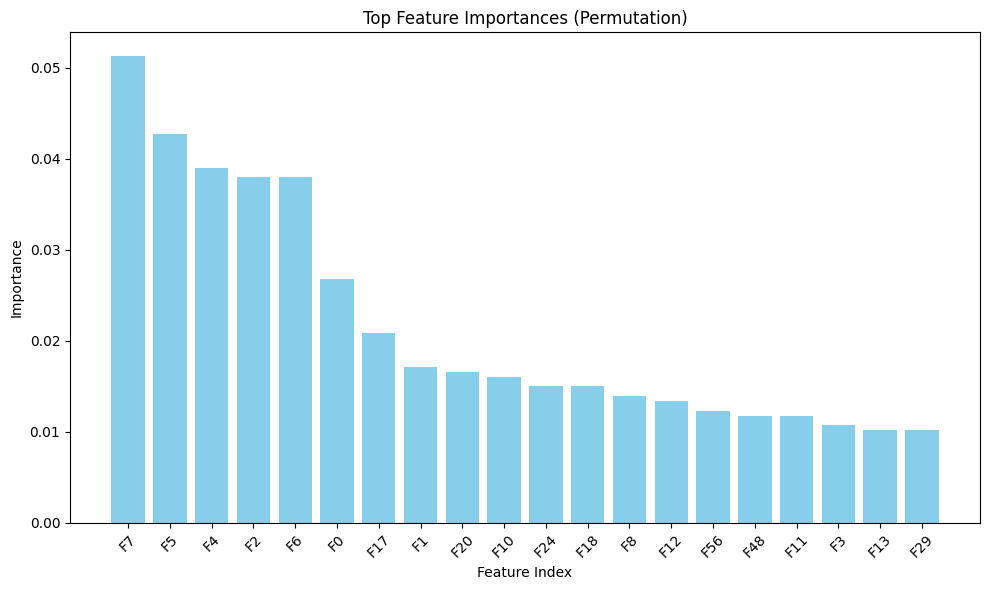

In [ ]:
top_indices, top_importances = interpret_svm_features(
    svm_model, X_test, y_test, top_k=20, save_path="svm_feature_importance.png"
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Extract CNN features and labels
X_cnn = np.stack(feature_df['features'].values)
y_cnn = feature_df['label'].values

# Step 2: Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn, test_size=0.2, stratify=y_cnn, random_state=42
)

# Step 3: Train SVM
svm_cnn = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_cnn.fit(X_train_cnn, y_train_cnn)

# Step 4: Predict and evaluate
y_pred_cnn = svm_cnn.predict(X_test_cnn)
print("CNN-Only Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn))


CNN-Only Classification Report:
              precision    recall  f1-score   support

          AD       0.62      0.55      0.58        62
          CN       0.61      0.18      0.28        62
        LMCI       0.50      0.90      0.64        63

    accuracy                           0.55       187
   macro avg       0.58      0.54      0.50       187
weighted avg       0.58      0.55      0.50       187



In [ ]:
print("CNN-Only Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn))


CNN-Only Classification Report:
              precision    recall  f1-score   support

          AD       0.62      0.55      0.58        62
          CN       0.61      0.18      0.28        62
        LMCI       0.50      0.90      0.64        63

    accuracy                           0.55       187
   macro avg       0.58      0.54      0.50       187
weighted avg       0.58      0.55      0.50       187



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Step 1: Extract ViT features and labels
X_vit = np.stack(vit_feature_df['features'].values)
y_vit = vit_feature_df['label'].values

# Step 2: Train-test split
X_train_vit, X_test_vit, y_train_vit, y_test_vit = train_test_split(
    X_vit, y_vit, test_size=0.2, stratify=y_vit, random_state=42
)

# Step 3: Train SVM
svm_vit = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_vit.fit(X_train_vit, y_train_vit)

# Step 4: Predict and evaluate
y_pred_vit = svm_vit.predict(X_test_vit)
print("ViT-Only Classification Report:")
print(classification_report(y_test_vit, y_pred_vit))


ViT-Only Classification Report:
              precision    recall  f1-score   support

          AD       0.59      0.53      0.56        62
          CN       0.80      0.13      0.22        62
        LMCI       0.51      0.98      0.67        63

    accuracy                           0.55       187
   macro avg       0.63      0.55      0.49       187
weighted avg       0.63      0.55      0.49       187



In [ ]:
print("ViT-Only Classification Report:")
print(classification_report(y_test_vit, y_pred_vit))


ViT-Only Classification Report:
              precision    recall  f1-score   support

          AD       0.59      0.53      0.56        62
          CN       0.80      0.13      0.22        62
        LMCI       0.51      0.98      0.67        63

    accuracy                           0.55       187
   macro avg       0.63      0.55      0.49       187
weighted avg       0.63      0.55      0.49       187



Weighted Fusion Based on Feature Importance

In [ ]:
def normalize_importance(importances, total_dims=512):
    weights = np.zeros(total_dims)
    for idx, score in zip(top_indices, top_importances):
        weights[idx] = score
    weights /= np.sum(weights)  # Normalize to sum = 1
    return weights


In [ ]:
def apply_weighted_fusion(fused_df, weights):
    X = np.stack(fused_df['features'].values)
    X_weighted = X * weights  # Element-wise weighting

    weighted_df = pd.DataFrame({
        'features': list(X_weighted),
        'label': fused_df['label'].values,
        'subject_id': fused_df['subject_id'].values
    })

    return weighted_df


In [ ]:
reduced_df = apply_pca(fused_df, n_components=512)


PCA explained variance ratio (top 512): 0.9649


In [ ]:
def apply_weighted_fusion(reduced_df, weights):
    X = np.stack(reduced_df['features'].values)
    X_weighted = X * weights  # Now shapes match: (933, 512) × (512,)

    weighted_df = pd.DataFrame({
        'features': list(X_weighted),
        'label': reduced_df['label'].values,
        'subject_id': reduced_df['subject_id'].values
    })

    return weighted_df


In [ ]:
weights = normalize_importance(top_importances, total_dims=512)
weighted_df = apply_weighted_fusion(reduced_df, weights)


X = np.stack(weighted_df['features'].values)
y = weighted_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

svm_weighted = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_weighted.fit(X_train, y_train)
y_pred = svm_weighted.predict(X_test)

print("Weighted Fusion Classification Report:")
print(classification_report(y_test, y_pred))


Weighted Fusion Classification Report:
              precision    recall  f1-score   support

          AD       0.65      0.52      0.58        62
          CN       0.59      0.32      0.42        62
        LMCI       0.50      0.83      0.62        63

    accuracy                           0.56       187
   macro avg       0.58      0.55      0.54       187
weighted avg       0.58      0.56      0.54       187



Contrastive Alignment of CNN and ViT Streams

In [ ]:
# Step 1.1: Split fused features back into CNN and ViT
cnn_features = np.stack(fused_df['features'].apply(lambda x: x[:len(x)//2]))
vit_features = np.stack(fused_df['features'].apply(lambda x: x[len(x)//2:]))
labels = fused_df['label'].values


In [ ]:
# Step 1.2: Infer dimensions from a sample
sample_vector = fused_df['features'].iloc[0]
D_total = len(sample_vector)

# If CNN and ViT were equal-length:
cnn_dim = vit_dim = D_total // 2

# Split features
cnn_features = np.stack(fused_df['features'].apply(lambda x: x[:cnn_dim]))
vit_features = np.stack(fused_df['features'].apply(lambda x: x[cnn_dim:]))
labels = fused_df['label'].values


In [ ]:
print("CNN shape:", cnn_features.shape)
print("ViT shape:", vit_features.shape)
print("Labels shape:", labels.shape)


CNN shape: (933, 89216)
ViT shape: (933, 89216)
Labels shape: (933,)


Defining Contrastive Loss

In [ ]:
import torch
import torch.nn.functional as F

def contrastive_loss(cnn_embed, vit_embed, labels, margin=0.5):
    batch_size = cnn_embed.size(0)
    loss = 0.0

    for i in range(batch_size):
        for j in range(batch_size):
            if i == j:
                continue
            sim = F.cosine_similarity(cnn_embed[i], vit_embed[j], dim=0)
            if labels[i] == labels[j]:
                loss += (1 - sim)  # pull together
            else:
                loss += F.relu(sim - margin)  # push apart

    return loss / (batch_size * (batch_size - 1))


In [ ]:
# Step 2.1: Create label mapping
label_map = {'AD': 0, 'CN': 1, 'LMCI': 2}
labels_encoded = np.array([label_map[label] for label in labels])

# Step 2.2: Convert to PyTorch tensor
label_tensor = torch.tensor(labels_encoded, dtype=torch.long)


In [ ]:
print("Encoded labels:", np.unique(labels_encoded))
print("Tensor shape:", label_tensor.shape)


Encoded labels: [0 1 2]
Tensor shape: torch.Size([933])


Building Alignment Networks

In [ ]:
import torch.nn as nn

class AlignmentNet(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super().__init__()
        self.project = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.project(x)


In [ ]:
cnn_net = AlignmentNet(input_dim=89216, output_dim=128)
vit_net = AlignmentNet(input_dim=89216, output_dim=128)


Training Loop

In [ ]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch.optim as optim

# Step 4.1: Move networks to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_net = cnn_net.to(device)
vit_net = vit_net.to(device)

# Step 4.2: Prepare data
cnn_tensor = cnn_tensor.to(device)
vit_tensor = vit_tensor.to(device)
label_tensor = label_tensor.to(device)

# Step 4.3: Optimizer
optimizer = optim.Adam(list(cnn_net.parameters()) + list(vit_net.parameters()), lr=1e-3)

# Step 4.4: Training loop
num_epochs = 10
for epoch in range(num_epochs):
    cnn_embed = cnn_net(cnn_tensor)
    vit_embed = vit_net(vit_tensor)

    loss = contrastive_loss(cnn_embed, vit_embed, label_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs} - Contrastive Loss: {loss.item():.4f}")


NameError: name 'torch' is not defined